In [11]:
import os
import numpy as np
import pandas as pd
import seaborn as sns;sns.set()
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
from matplotlib import cm
from pandas import read_csv, set_option
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier,CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.feature_selection import SelectKBest,f_regression
from xgboost import plot_importance,XGBClassifier,XGBRegressor
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing
import shap

from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import FastICA
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

# for dirname, _, filenames in os.walk('/kaggle/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
import time
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
%matplotlib inline

# time series cross validation
# https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

''' FUNCTIONS '''

# One plot type
def plot_line(ldf,lst,title='',sec_id=None,size=[350,1000]):
    
    # sec_id - list of [False,False,True] values of when to activate supblots; same length as lst
    
    if(sec_id is not None):
        fig = make_subplots(specs=[[{"secondary_y": True}]])
    else:
        fig = go.Figure()
        
    if(len(lst) is not 1):
        ii=-1
        for i in lst:
            ii+=1
            if(sec_id is not None):
                fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[ii]],mode='lines',name=lst[ii],line=dict(width=2.0)),secondary_y=sec_id[ii])
            else:
                fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[ii]],mode='lines',name=lst[ii],line=dict(width=2.0)))
    else:
        fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[0]],mode='lines',name=lst[0],line=dict(width=2.0)))

    fig.update_layout(height=size[0],width=size[1],template='plotly_white',title=title,
                          margin=dict(l=50,r=80,t=50,b=40));fig.show()
    
# plot n verticle subplots
def plot_vsubplots(ldf,lst,title='',nplots=None,lw_id=None,size=[400,1000]):

    # lw_id list of line widths if added
        
    assert(nplots is not None) 
    fig = make_subplots(rows=nplots,shared_xaxes=True)
    ii=-1
    for i in lst:
        ii+=1
        fig.add_trace(go.Scatter(x=ldf.index,y=ldf[lst[ii]], mode='lines',name=lst[ii],line=dict(width=lw_id[ii])), row=ii+1, col=1) 

    fig.update_layout(height=size[0],width=size[1],template='plotly_white',title=title,
                          margin=dict(l=50,r=80,t=50,b=40));fig.show()
    
colours = ['tab:blue','tab:red','tab:green']
def plot_line2(ldf,lst,title=''):
    
    ii=-1
    plt.figure(figsize=(14,5))
    for i in lst:
        ii+=1
        ax = ldf[lst[ii]].plot(color=colours[ii],label=lst[ii],lw=1.5)
    plt.title(title)
    plt.legend();plt.show()
    
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot Correlation to Target Variable only
def corrMat(df,target='demand',figsize=(9,0.5),ret_id=False):
    
    corr_mat = df.corr().round(2);shape = corr_mat.shape[0]
    corr_mat = corr_mat.transpose()
    corr = corr_mat.loc[:, df.columns == target].transpose().copy()
    
    if(ret_id is False):
        f, ax = plt.subplots(figsize=figsize)
        sns.heatmap(corr,vmin=-0.3,vmax=0.3,center=0, 
                     cmap=cmap,square=False,lw=2,annot=True,cbar=False)
        plt.title(f'Feature Correlation to {target}')
    
    if(ret_id):
        return corr
    
def bar_plot(x, y,palette_len,title='Missing Values (%)', xlim = None, ylim = None, 
             xticklabels = None, yticklabels = None,xlabel = None, ylabel = None, 
             figsize = (10,4),axis_grid = 'y'):
        
    cmap = sns.color_palette("plasma")
    fig, ax = plt.subplots(figsize = figsize)
    plt.title(title,size = 15, fontweight = 'bold')

    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')
    
    ax.spines['top'].set_visible(True);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)

    sns.barplot(x = x, y = y, edgecolor = 'black', ax = ax,
                palette = cmap)
    ax.set_xlim(xlim);ax.set_ylim(ylim)    
    ax.set_xticklabels(xticklabels);ax.set_yticklabels(yticklabels)
    plt.xlabel(xlabel);plt.ylabel(ylabel)
    ax.grid(axis = axis_grid,ls='--',alpha = 0.9)
    plt.show()

# function to plot a two PCA Feature Plot using Pandas 
def scatterPlot(xDF, yDF, algoName):
    
    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["Component 1","Component 2","Label"]
    g = sns.scatterplot(x="Component 1",y="Component 2",data=tempDF,hue="Label",
                        linewidth=0.5,alpha=0.5,s=15,edgecolor='k')
    plt.title(algoName);plt.legend()
    
    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')
    
    ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)
    ax.grid(axis = 'both',ls='--',alpha = 0.9)
    plt.show()
    
    
# reduce memory (@mfjwr1); distorts the data a little (but reduces by 60% memory)
def red_mem(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Split for TimeSeries
def TimeSeries_Split(ldf,
                     split_id=[None,None],
                     test_id=False,
                     cut_id=None):
    
    # Reduce the number of used data
    if(cut_id is not None):
        print('Reducing Input Data')
        
        if(type(cut_id) is int):
            ldf = ldf.iloc[-cut_id:]
        else:
            # input anything other than int
            print('Slicing based on period')
            ldf = ldf[data_period]
            
        t1 = ldf.index.max();t0 = ldf.index.min()
        print(f'Dataset Min.Index: {t0} | Max.Index: {t1}')
        
    if(split_id[0] is not None):
        # General Percentage Split (Non Shuffle requied for Time Series)
        train_df,pred_df = train_test_split(ldf,test_size=split_id[0],shuffle=False)
    elif(split_id[1] is not None):
        # specific time split 
        train_df = df.loc[:split_id[1]]; pred_df = df.loc[split_id[1]:] 
    else:
        print('Choose One Splitting Method Only')
        
#     y_train = train_df[feature]
#     X_train = train_df.loc[:, train_df.columns != feature]
#     if(test_id):
#         y_test = pred_df[feature]
#         X_test = pred_df.loc[:, pred_df.columns != feature]
        
    return train_df,pred_df # return 

![Bitcoin Introduction](https://i.imgur.com/j5CTpDr.png)

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#CDE10F"><b><span style='color:#FFFFFF'>1 |</span></b> <b>INTRODUCTION</b></div>

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>FOREWORD</span></b></p></div>

- 최근에 (2020년만), 디지털 자산 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Bitcoin</mark>**은 단독으로 200% 이상 상승하여 새로운 최고치에 도달한 후 다시 하락했습니다.
- 이는 이 자산이 얼마나 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">휘발성</mark>** 있는지 보여주며, 이는 일반 주식과 달리 탐험하기에 더욱 흥미로운 시계열 데이터 중 하나로 만듭니다.
- 이 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">디지털 자산</mark>**이 최근 하락 후 가치가 다시 상승한 것을 보는 것은 특히 현재의 금융 상황에서 흥미롭습니다.
- 이 자산에 영향을 미칠 수 있는 여러 가지 요소가 있으며, 우리는 전통적인 주식 기반 요인만 살펴볼 것입니다.
- 이 노트북은 나만의 시계열 문제 연습 및 일반 함수/클래스 코딩을 위해 작성되었으며 관련 데이터셋은 매우 휘발성인 자산의 광범위한 데이터 가용성으로 인해 사용되었습니다.

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>DIGITAL ASSETS</span></b></p></div>

**[데이터셋 설명](https://www.kaggle.com/mczielinski/bitcoin-historical-data)** 스니펫

> Bitcoin은 익명의 Satoshi Nakamoto에 의해 2009년에 최초로 오픈 소스로 출시된 가장 오래되고 가장 잘 알려진 암호화폐입니다. Bitcoin은 신뢰할 수있는 기록 저장 기관이나 중앙 중개 업체가 필요하지 않은 공개 분산 원장 (블록 체인)에 거래가 검증되고 기록되는 분산형 디지털 교환의 역할을합니다. 거래 블록에는 이전 거래 블록의 SHA-256 암호 해시가 포함되어 있으며 따라서 모든 거래의 변경 불가능한 기록 역할을하며 "체인"되어 있습니다. 시장에서 어떤 통화/상품이든 마찬가지로 Bitcoin의 공개적인 채택 이후 Bitcoin 거래 및 금융 도구가 따라왔으며 계속 성장하고 있습니다. 여기에는 거래가 발생하는 선택한 Bitcoin 거래소에서의 1분 간격의 역사적인 Bitcoin 시장 데이터가 포함되어 있습니다. 행운을 빕니다! 


<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>주가 영향 요인</span></b></p></div>

주가 예측에 유용한 특성은 <b>Tatsat et al (2020)</b>에 의해 개요로 제시된 바와 같습니다.

##### **상관된 자산**

> 조직은 경쟁사, 고객, 세계 경제, 지정학적 상황, 재정 및 통화 정책, 자본 접근 등과 같은 다양한 외부 요인에 의존하고 상호 작용합니다. 따라서 주식 가격은 다른 기업의 주식뿐만 아니라 원자재, 환율, 종합 지수 또는 고정 소득 증권과 같은 다른 자산과 상관 관계가 있을 수 있습니다.

##### **기술적 지표**

> 많은 투자자들은 기술적 지표를 따릅니다. 이동 평균, 지수 이동 평균 및 모멘텀은 가장 인기 있는 지표입니다.

##### **기술적 보고서**

> 기업의 연간 및 분기 보고서는 ROE (자기 자본 이익률) 및 P/E (주당 주가 수익률)와 같은 주요 지표를 추출하거나 결정하는 데 사용될 수 있습니다.

##### **뉴스 보도**

> 뉴스는 특정 방향으로 주식 가격을 움직일 수 있는 예정 이벤트를 나타낼 수 있습니다.

- **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">주가</mark>**에 중점을 둘 때, 변수 구축 및 조립에 대해 위에서 설명한 몇 가지 접근 방식을 사용할 수 있습니다
- **([출처](https://cryptobriefing.com/is-bitcoin-stock-commodity/))**에서 나타낸 바와 같이, <code>Bitcoin</code>은 주식이나 통화보다는 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">디지털 자산</mark>**이기 때문에 설명된 요인들이 <code>Bitcoins</code>와 관련된 분석에 완전히 관련이 있는지 여부는 분명하지 않습니다.
- 그러나 **([출처](https://www.mycryptopedia.com/best-8-bitcoin-indicators-for-cryptocurrency-trading/))**은 특히 <code>Bitcoin</code> 가격 방향성 예측에 유용한 다양한 <code>지표</code>들을 개요로 설명하고 있습니다. 이는 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">기술적 지표</mark>**가 <code>Bitcoin</code>의 시계열에서 중요한 역할을 하는 것을 보여줍니다 


<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>문제 정의</span></b></p></div>

- 암호화폐 거래의 주요 단점 중 하나는 시장의 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">변동성</mark>**입니다.
- 통화 거래는 24/7 이 일어날 수 있으며 암호화 포지션을 추적하는 것은 자동화 없이는 관리하기 어려운 작업일 수 있습니다.
- 자동화 된 기계 학습 거래 알고리즘은 시장의 움직임을 예측하는 데 도움을줄 수 있으며 미래 움직임을 세 가지 범주로 분류 할 수 있습니다.

> <code>(1) 시장이 상승할 것이다 (긴 포지션을 취함)</code>, <br>
> <code>(2) 시장이 하락할 것이다 (숏 포지션 취함)</code> <br>
> <code>(3) 시장이 수평으로 움직일 것이다 (포지션을 취하지 않음)</code>.
    
    
- **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">거래 전략</mark>**을 위한 매수 (<code>value=1</code>) 또는 매도 (<code>value=0</code>) 신호를 예측하는 문제는 분류 프레임워크에서 정의됩니다. 
- 매수 또는 매도 신호는 단기 대 장기 가격을 비교함으로써 결정되며 <code>Section 2.2</code>에서 정의되었습니다.
- 데이터 수집 및 <code>feature engineering</code>은 시계열 모델 개선에 관련된 요소입니다. 
- 흥미로운 점은 전통적으로 주식 지향적인 <code>feature engineering</code> 수정이 <code>digital assets</code>에 적용 가능한지 여부 및 그렇다면 어떤지 조사하는 것입니다.
- 마지막으로, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">모델 생성 효율성</mark>**은 각 추가된 특성이 모델의 반환 시간에 상당한 영향을 미칠 수 있기 때문에 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">고빈도 틱 데이터</mark>**를 처리할 때 훨씬 중요해집니다. 모델 정확성 및 모델 출력 반환 시간의 균형을 유지하는 것은 분명히 관리할 가치가 있습니다.

<div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#CDE10F"><b><span style='color:#FFFFFF'>2 |</span></b> <b>데이터셋</b></div>

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>데이터셋 읽기</span></b></p></div>

- 현재 데이터셋 : 2012년 1월부터 2020년 9월까지의 특정 비트코인 거래소에 대한 CSV 파일, <code>1분 간격 데이터</code> ([데이터셋](https://www.kaggle.com/mczielinski/bitcoin-historical-data))
- <code>timestamp</code> 특성은 <code>pytz</code> 라이브러리를 사용하여 더 일반적인 시간 인덱스로 구문 분석 할 수 있습니다.
- <code>Baseline Features</code>에는 자산의 분 단위의 <code>open</code>,<code>high</code>,<code>low</code>,<code>close</code>,<code>Volume_(BTC)</code>,<code>Volume_(Currency)</code> 및 <code>Weighted_Price</code>이 포함됩니다.
- 로드된 데이터셋에는 특정 시작 및 종료 시간 인덱스가 있으며 모델을 보지 않은 데이터에 사용하려면 데이터셋을 분할하고 확인하지 않아야 합니다. 사용된 코드는 아래에 숨겨져 있습니다.


In [12]:
import datetime, pytz
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

# Data Periods used in Notebook
plot_period = slice('2020-7-7 0:00','2020-7-7 8:00') # Selectio Plot Period for visualisation only
data_period = slice('2020-7-6 13:21','2020-9-14 0:00') # Select Data Period for Analysis

# Path to CSV
path = '/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'

In [13]:
import pandas as pd
# path = 'bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv'
df = pd.read_csv(path,parse_dates=[0],
                 date_parser=dateparse,
                 index_col='Timestamp')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4857377 entries, 2011-12-31 07:52:00+00:00 to 2021-03-31 00:00:00+00:00
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Open               float64
 1   High               float64
 2   Low                float64
 3   Close              float64
 4   Volume_(BTC)       float64
 5   Volume_(Currency)  float64
 6   Weighted_Price     float64
dtypes: float64(7)
memory usage: 296.5 MB


In [14]:
# It's possible to reduce the dataframe memory by 62% (if you need)
# red_df = red_mem(df)

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>데이터 부분집합 작업</span></b></p></div>

- 우리에게 제공된 지표 데이터가 많기 때문에 모델의 교육은 꽤 오래 걸릴 수 있습니다. 특히 교차 유효성 검사의 경우입니다.
- 이 노트북에서는 예측하려는 내용과 가장 관련이 있을 것으로 예상되는 <code>100,000</code> (4.5M 대비) 최근 데이터 포인트로 데이터셋을 제한해 보겠습니다.
- <code>2개월간의 교육 데이터</code>만으로는 매우 정확한 모델을 얻기에 충분하지 않을 수 있습니다 (짧은 기간이지만 상당한 데이터를 포함하므로 일부 추세를 놓칠 수 있지만, 더 강력한 PC가 있다면 더 많은 포인트를 시도할 수 있습니다).
- 물론 더 큰 데이터셋을 처리하는 데 유용한 응용 프로그램 중 하나는 <code>GPU</code> 대응 모델입니다. 
- 매우 간단하고 쉽게 사용할 수 있는 <code>XGBoost</code>의 GPU 대응 모델 예제는 [hamditarek](https://www.kaggle.com/hamditarek/market-prediction-xgboost-with-gpu-fit-in-1min?q=XGboost+GPU)에서 제공됩니다.


시계열 데이터셋 2개월로 제한

In [15]:
df_tr,df_te = TimeSeries_Split(df,split_id=[0.2,None], #  Train/Test Split (0.8/0.2)
                               cut_id=data_period)     # Use only 100,000 data points 

Reducing Input Data
Slicing based on period
Dataset Min.Index: 2020-07-06 13:21:00+00:00 | Max.Index: 2020-09-14 00:00:00+00:00


<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>데이터 정리</span></b></p></div>

- 결측 데이터는 시각화되었으며 특징 간에 일관되게 나타납니다.
- 거래가 발생하지 않은 기간의 지표 데이터를 채우기 위해 <code>value=0</code> (<b>무시</b>)로 적용된 단일 이벤트를 살려냅니다.
- 연속 시계열이므로 특징 <code>open</code>,<code>high</code>,<code>low</code>,<code>close</code>를 앞쪽 채우기 (<code>ffil</code>)를 사용하여 수정합니다.

결측치 시각화:
결측치를 시각화하고 해당 결측치가 특성 간에 일관되게 나타나는 것을 확인합니다.
거래가 발생하지 않은 인덱스의 결측치 처리:
거래가 발생하지 않은 인덱스에 대한 데이터를 단일 이벤트 값인 0으로 채웁니다.
아마도 거래가 없는 기간 동안 해당 값을 0으로 채워 해당 시기에 거래가 없었음을 나타내려는 것으로 이해됩니다.
시계열 특성(open, high, low, close) 수정:
시계열 특성(open, high, low, close)을 시간 순서대로 연속적으로 수정하려면 전방 채우기 (ffill)를 사용합니다.
전방 채우기는 결측치를 가장 최근의 결측치가 아닌 값으로 채우는 것을 의미합니다. 이는 값이 자주 연속적이고 상관된 시계열 데이터에서 유용합니다.

데이터프레임(df_tr)에서 각 열의 결측치 비율을 계산하고, 이를 시각화하기 위해 막대 그래프를 생성

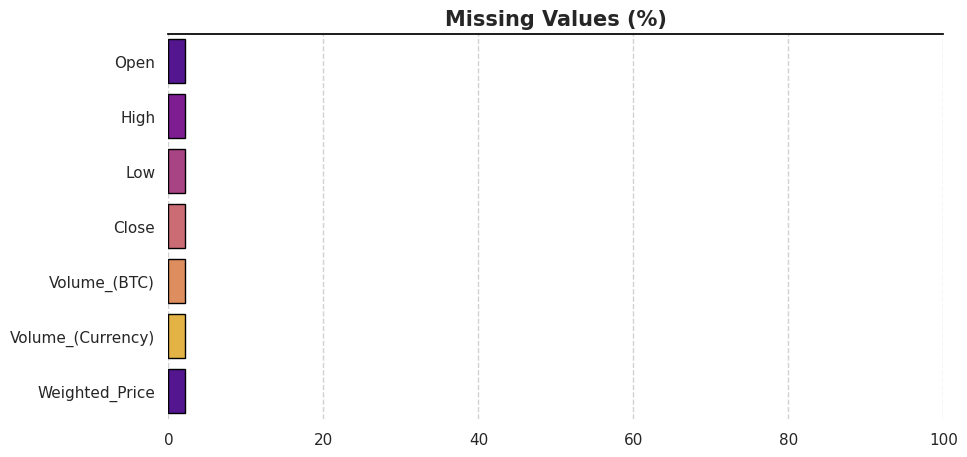

In [16]:
NaN_values = (df_tr.isnull().sum()/len(df_tr)*100).sort_values(ascending = False)

# Plot missing data
bar_plot(x = NaN_values,y = NaN_values.index,palette_len = NaN_values.index, 
         xlim = (0,100),xticklabels = range(0,101,20),yticklabels = NaN_values.index,
         figsize = (10,5), axis_grid = 'x')

In [17]:
df_tr[df_tr.isna().any(axis=1)]

Open  High  Low  Close  Volume_(BTC)  \
Timestamp                                                         
2020-07-06 14:21:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-07-06 15:07:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-07-06 18:10:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-07-06 21:12:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-07-06 21:17:00+00:00   NaN   NaN  NaN    NaN           NaN   
...                         ...   ...  ...    ...           ...   
2020-08-30 12:45:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-08-30 14:14:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-08-30 14:18:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-08-30 16:00:00+00:00   NaN   NaN  NaN    NaN           NaN   
2020-08-31 01:00:00+00:00   NaN   NaN  NaN    NaN           NaN   

                           Volume_(Currency)  Weighted_Price  
Timestamp                                                     
2020-07-06 14:21:00+00:00                NaN             NaN  
2020-07-06 15:07:00+00:00                NaN             NaN  
2020-07-06 18:10:00+00:00                NaN             NaN  
2020-07-06 21:12:00+00:00                NaN             NaN  
2020-07-06 21:17:00+00:00                NaN             NaN  
...                                      ...             ...  
2020-08-30 12:45:00+00:00                NaN             NaN  
2020-08-30 14:14:00+00:00                NaN             NaN  
2020-08-30 14:18:00+00:00                NaN             NaN  
2020-08-30 16:00:00+00:00                NaN             NaN  
2020-08-31 01:00:00+00:00                NaN             NaN  

[1749 rows x 7 columns]

Prediction with non events <code>.fillna(0)</code> can be interesting to include in signal modelling, but excluded here to have a more visible stock fluctuation history.
이벤트가 발생하지 않은 경우의 예측은 .fillna(0)을 사용하여 0으로 채우는 것이 모델링에서 흥미로울 수 있지만, 여기서는 주식 가격의 변동 내역을 더 명확하게 보기 위해 제외하였다

In [18]:
def forward_fill_na(ldf):
    # ldf['Volume_(BTC)'].fillna(0, inplace=True)
    # ldf['Volume_(Currency)'].fillna(0, inplace=True)
    # ldf['Weighted_Price'].fillna(0, inplace=True)
    ldf['Open'].fillna(method='ffill', inplace=True)
    ldf['High'].fillna(method='ffill', inplace=True)
    ldf['Low'].fillna(method='ffill', inplace=True)
    ldf['Close'].fillna(method='ffill', inplace=True)
    
forward_fill_na(df_tr)  # modification of training set
forward_fill_na(df_te) # modification of test set

In [19]:
#df = df.drop_duplicates(keep=False,inplace=True) 
df_tr = df_tr.dropna() 
df_te = df_te.dropna()     # replicate on test set

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#CDE10F"><b><span style='color:#FFFFFF'>3 |</span></b> <b>데이터 탐색</b></div>

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;">
    <p style="padding: 5px;color:white;text-align:left;">
        <b><span style='color:#CDE10F'>기술 통계</span></b>
    </p>
</div>

데이터셋의 숫자형 값에 대한 통계를 조사해 봅시다.


In [21]:
#set_option('precision',2)
#df_tr.describe()

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;">
    <p style="padding: 5px;color:white;text-align:left;">
        <b><span style='color:#CDE10F'>타겟 변수</span></b>
    </p>
</div>

- 예측 변수 <code>signal</code>을 정의해야 합니다. 이는 <code>Close</code> 특성을 사용하여 <code>.rolling</code> 및 <code>.mean()</code>을 통해 수행됩니다.
- 단기 (윈도우) 이동 평균인 <code>SMA1</code> 및 장기 (윈도우) 이동 평균인 <code>SMA2</code>를 사용하여 대상 변수인 <code>signal</code>을 생성합니다.
- 거래 전략은 다음과 같습니다. <code>Short Term (SMA1)</code> > <code>Long Term (SMA2)</code>인 경우 신호 값은 1 <code>(매수)</code>로 설정되고, 그렇지 않으면 0 <code>(매도)</code>로 설정됩니다.
- <code>Short Term (SMA1)</code> 및 <code>Long Term (SMA2)</code> 이동 평균 값은 각각 <b>윈도우 값이 10 및 60</b>으로 설정되어 있으며, 이는 임의의 값이며 결과에 영향을 미칠 수 있습니다. 이상적으로는 최적의 값 찾기 위해 최적화 연구를 수행해야 합니다.
</p>


In [22]:
def create_target(ldf,tr_id=False):
    ldf['SMA1'] = ldf['Close'].rolling(window=10, min_periods=1, center=False).mean() #  short simple moving average window
    ldf['SMA2'] = ldf['Close'].rolling(window=60, min_periods=1, center=False).mean() #  long simple moving average window
    ldf['signal'] = np.where(ldf['SMA1'] > ldf['SMA2'], 1.0, 0.0) # Create signals
    if(tr_id is not True):
        display(ldf['signal'].value_counts())
    
df_tr1 = df_tr.copy()  # Save the Baseline Model Dataframe [Training Set]
df_te1 = df_te.copy() # Save the Baseline Model Dataframe [Test Set]
create_target(df_tr1)  # Add target variable to Training Set 
create_target(df_te1,tr_id=True)  # Add target variable to Test Set

signal
1.0    40125
0.0    38126
Name: count, dtype: int64

- 상대적으로 균일한 (매수/매도) 분포인 <code>signal</code> 타겟 변수가 있습니다 (40,000건/38,000건).
- 이 문제에서는 <code>클래스 불균형</code>과 관련된 문제에 대해 강조할 필요가 없습니다.
- 이진 분류 모델의 평가 지표로는 ROC 및 PR 곡선보다는 간단한 지표인 <code>정확도, 재현율, 정밀도</code> 같은 메트릭이 충분할 수 있습니다.

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;">
    <p style="padding: 5px;color:white;text-align:left;">
        <b><span style='color:#CDE10F'>데이터셋 시계열 시각화</span></b>
    </p>
</div>

훈련 데이터 기간 동안의 전체 자산 가격 히스토리와 연관된 <code>signal</code>을 시각화해 봅시다.

In [23]:
plot_vsubplots(df_tr1,['Close','signal'],
               title='Weighted Price & Signal Fluctional in Training Data',
               nplots=2,
               lw_id=[2,0.4],
               size=[500,1000])

- <code>가중치가 적용된</code> 자산 가격의 일반적인 상승 트렌드를 주목하는 것이 흥미로운데, 이 기간의 시작부터 9,200에서 몇 달 사이에 11,730까지 상승했습니다.
- 시각화가 쉽지 않지만, 신호 (모델링할 대상)도 플로팅되어 있습니다. 이 짧은 기간 동안에 얼마나 단기 및 장기 이동 평균이 교차되는지 관찰할 수 있습니다.

In [24]:
# Visualise Training Set Target Variable Related Features

lst_MAV = ['SMA1','SMA2','signal']
ldf = df_tr1.loc[plot_period,lst_MAV]
plot_line(ldf,lst_MAV,
          title='SM1, SMA2 & Signal created from Closing Price',
          sec_id=[False,False,True])  

단기 및 장기 이동 평균 값이 교차되는 기간이 꽤 많음을 볼 수 있습니다. 심지어 <b>8시간</b> 동안에도 관찰된 기간 동안 비용이 <code>9,240에서 9,400</code> 범위로 변동되었으며, 이는 고도로 변동성이 높은 자산을 나타냅니다.


In [25]:
df_tr1=df_tr1.drop(['SMA1','SMA2'], axis=1)
df_te1=df_te1.drop(['SMA1','SMA2'], axis=1)   # replicate on test data

### <b><span style='color:#CDE10F'> 3.1 |</span> 기준 모델 특성</b>

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;">
    <p style="padding: 5px;color:white;text-align:left;">
        <b><span style='color:#CDE10F'>기준 특성 상관관계</span></b>
    </p>
</div>

기준 용어를 정의해 봅시다. 데이터셋에서 사용 가능한 특성인 **open**, **close** 등입니다.
- 현재 특성인 <code>open</code>,<code>high</code>,<code>low</code>,<code>close</code>,<code>volumes</code>,<code>weighted_price</code>의 선형 상관관계 값은 대상 변수에 대해 매우 미미합니다.
- 이는 여러 가지를 나타낼 수 있습니다. <code>높은 비선형성</code>, <code>정적 값에 대한 안정적인 진동</code> (원형 산점도) 또는 아마도 이러한 특성이 대상인 <code>signal</code>을 모델링하는 데 가장 이상적이지 않을 수 있으며 개선이 필요할 수 있습니다. 따라서 <code>특성 엔지니어링</code>에 주의가 기울어집니다.

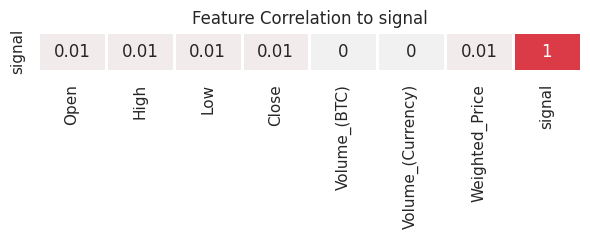

In [26]:
corrMat(df_tr1,'signal',figsize=(7,0.5)) # Baseline Dataframe feature correlation to Signal

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;">
    <p style="padding: 5px;color:white;text-align:left;">
        <b><span style='color:#CDE10F'>피쳐 엔지니어링</span></b>
    </p>
</div>

- 소개에서 언급한대로, 현재 문제에서는 <code>기술 지표</code>에 중점을 두어 <code>특성 엔지니어링</code> 접근 방식의 일부로 대한 더 많은 관련 특성을 <code>특성 행렬</code>에 도입하려고 합니다.
- (디지털 자산의 맥락에서 특히 흥미로운 것은) 어떤 특성이 모델의 성능에 영향을 미치는지, 그렇다면 어떤 영향을 미치는지를 알아보는 것입니다.

<b>구체적으로:</b>

> - <code>이동 평균</code> : 노이즈의 양을 줄이는 방식으로 가격 움직임의 추세를 나타냅니다. <br>
> - <code>스토캐스틱 오실레이터 %K 및 %D</code> : 스토캐스틱 오실레이터는 특정 종가를 일정 기간 동안의 가격 범위와 비교하는 모멘텀 지표입니다. %K 및 %D는 느린 및 빠른 지표입니다. <br>
> - <code>상대 강도 지수(RSI)</code> : 최근 가격 변동의 크기를 측정하여 주식이나 다른 자산의 과매수 또는 과매도 상태를 평가하는 모멘텀 지표입니다. [0,100] 범위. <b>자산 -> 70: 과매수</b>. <b>자산 -> 30: 과소매도 & 저평가된 자산</b>.<br>
> - <code>변동률(ROC)</code>: 현재 가격과 n 기간 전 가격 사이의 백분율 변화를 측정하는 모멘텀 오실레이터입니다. <b>높은 ROC 값</b>을 가진 자산은 과매수일 가능성이 높으며, <b>낮은 ROC</b>은 과소매도일 가능성이 높습니다.<br>
> - <code>모멘텀 (MOM)</code> : 가격이나 거래량의 가속도 비율입니다. <br>

모두 다양한 정도의 영향을 미칠 수 있으며, 이를 사용하여 대상 변수 <code>signal</code>을 모델링할 수 있습니다.


In [27]:
df_tr2 = df_tr1.copy()  # Create duplicate dataframe & add features to it
df_te2 = df_tr2.copy()

In [28]:
''' Technical Indicators '''

#Calculation of moving average
def ma(df, n):
    return pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))

# exponentially weighted moving average 
def ema(df, n):
    return pd.Series(df['Close'].ewm(span=n,min_periods=n).mean(), name='EMA_' + str(n))

#Calculation of price momentum
def mom(df, n):     
    return pd.Series(df.diff(n), name='Momentum_' + str(n))  

# rate of change
def roc(df, n):  
    M = df.diff(n - 1) ; N = df.shift(n - 1)  
    return pd.Series(((M / N) * 100), name = 'ROC_' + str(n)) 

# relative strength index
def rsi(df, period):
    delta = df.diff().dropna()
    u = delta * 0; d = u.copy()
    u[delta > 0] = delta[delta > 0]; d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

# stochastic oscillators slow & fast
def sto(close, low, high, n,id): 
    stok = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    if(id is 0):
        return stok
    else:
        return stok.rolling(3).mean()

In [29]:
def tech_indi(ldf,tr_id=True):

    ''' Moving Average '''
    ldf['MA21'] = ma(ldf,10)
    ldf['MA63'] = ma(ldf, 30)
    ldf['MA252'] = ma(ldf, 200)
    lst_MA = ['MA21','MA63','MA252']

    ''' Exponentially Weighted Moving Average '''
    ldf['EMA10'] = ema(ldf, 10)
    ldf['EMA30'] = ema(ldf, 30)
    ldf['EMA200'] = ema(ldf, 200)
    lst_EMA = ['EMA10','EMA30','EMA200']

    ''' Momentum '''
    ldf['MOM10'] = mom(ldf['Close'], 10)
    ldf['MOM30'] = mom(ldf['Close'], 30)
    lst_MOM = ['MOM10','MOM30']

    ''' Relative Strength Index '''
    ldf['RSI10'] = rsi(ldf['Close'], 10)
    ldf['RSI30'] = rsi(ldf['Close'], 30)
    ldf['RSI200'] = rsi(ldf['Close'], 200)
    lst_RSI = ['RSI10','RSI30','RSI200']

    ''' Slow Stochastic Oscillators '''
    ldf['%K10'] = sto(ldf['Close'], ldf['Low'], ldf['High'],5,0)
    ldf['%K30'] = sto(ldf['Close'], ldf['Low'], ldf['High'],10,0)
    ldf['%K200'] = sto(ldf['Close'], ldf['Low'], ldf['High'], 20,0)
    lst_pK = ['%K10','%K30','%K200']

    ''' Fast Stochastic Oscillators '''
    ldf['%D10'] = sto(ldf['Close'], ldf['Low'], ldf['High'], 10,1)
    ldf['%D30'] = sto(ldf['Close'], ldf['Low'], ldf['High'], 30,1)
    ldf['%D200'] = sto(ldf['Close'], ldf['Low'], ldf['High'], 200,1)
    lst_pD = ['%D10','%D30','%D200']
    
    # Plot Training Data
    if(tr_id):
        plot_line(ldf.loc[plot_period,lst_MA],lst_MA,title='Moving Average (window=21,63,252)')
        plot_line(ldf.loc[plot_period,lst_EMA],lst_EMA,title='Exponential Moving Average (window=10,30,200)')
        plot_line(ldf.loc[plot_period,lst_MOM],lst_MOM,title='Momentum')
        plot_line(ldf.loc[plot_period,lst_RSI],lst_RSI,title='Relative Strength Index')
        plot_line(ldf.loc[plot_period,lst_pK],lst_pK,title='Stochastic Oscillators (slow)')
        plot_line(ldf.loc[plot_period,lst_pD],lst_pD,title='Stochastic Oscillators (Fast)')

In [30]:
tech_indi(df_tr2) # add technical features to training set
tech_indi(df_te2,tr_id=False) # add technical features to test set

In [31]:
# All the current features
df_tr2.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price', 'signal', 'MA21', 'MA63', 'MA252', 'EMA10', 'EMA30',
       'EMA200', 'MOM10', 'MOM30', 'RSI10', 'RSI30', 'RSI200', '%K10', '%K30',
       '%K200', '%D10', '%D30', '%D200'],
      dtype='object')

### <b><span style='color:#CDE10F'> 3.2 |</span> Updated Feature Model Features</b>

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;">
    <p style="padding: 5px;color:white;text-align:left;">
        <b><span style='color:#CDE10F'>업데이트된 특성 선형 상관관계</span></b>
    </p>
</div>

- 새로운 Features 인 <code>MA</code>,<code>EMA</code>,<code>MOM</code>,<code>RSI</code>,<code>%K/%D</code>를 생성한 후,
- 이러한 새로운 Features와 대상 변수 간의 선형 상관관계를 조사하고 <code>기준 데이터셋</code>의 특성과 비교해 봅시다.


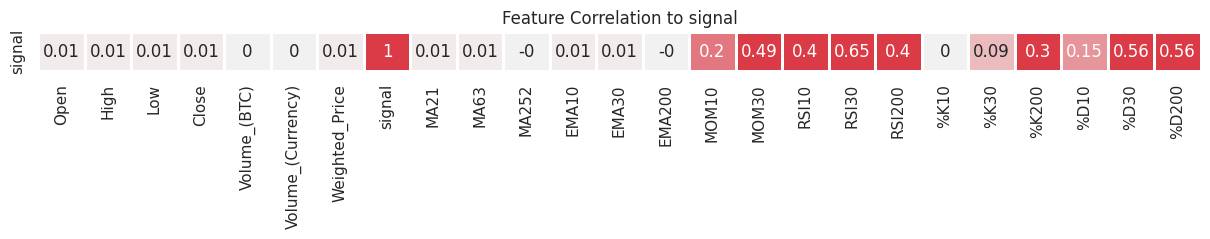

In [32]:
corrMat(df_tr2,'signal',figsize=(15,0.5))

- <code>피쳐 엔지니어링</code> 결과로 생성된 선형 상관관계가 상당히 높은 특성 그룹을 볼 수 있습니다.
- 사용된 경우 기준 데이터셋 특성이 대상 변수의 변화에 거의 영향을 미치지 않을 것으로 예상됩니다.
- 반면에 새롭게 생성된 특성은 상당히 다양한 상관관계 값을 가지고 있으며, 상당히 중요한 것은 대상 변수인 <code>signal</code>과 너무 높은 상관관계를 가지지 않는다는 것입니다.


In [33]:
def drp_feat(ldf):
    ldf = ldf.drop(['High','Low','Open','Volume_(Currency)'], axis=1) # let's drop most of the original feature
    
drp_feat(df_tr2)
drp_feat(df_te2)

<code>Feature matrix</code>에 함수를 적용한 후, 결측치를 다시 확인해야 합니다.


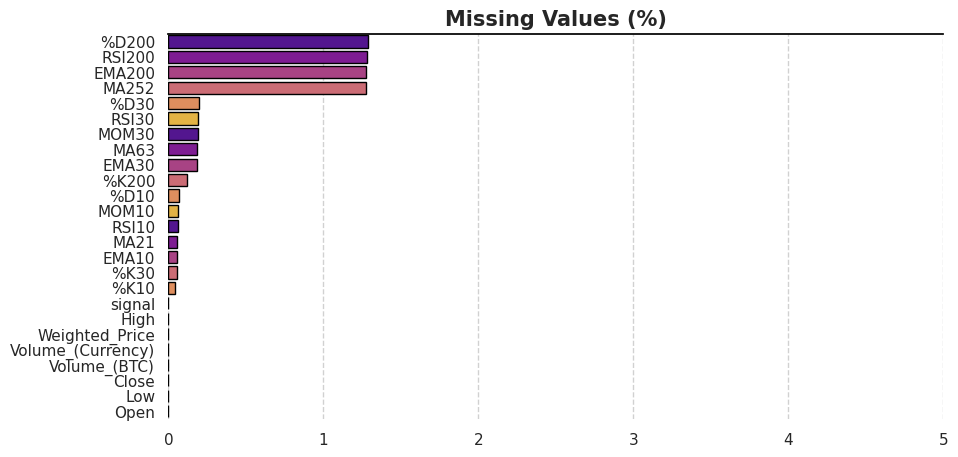

In [34]:
NaN_values = (df_tr2.isnull().sum() / len(df_tr2) * 100).sort_values(ascending = False)
bar_plot(x = NaN_values,y = NaN_values.index,palette_len = NaN_values.index, 
         xlim = (0,1),xticklabels = range(0,10),yticklabels = NaN_values.index,
         figsize = (10,5), axis_grid = 'x')

In [35]:
df_tr2 = df_tr2.dropna() 
df_te2 = df_te2.dropna()
df_tr2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78047 entries, 2020-07-06 16:44:00+00:00 to 2020-08-31 02:40:00+00:00
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               78047 non-null  float64
 1   High               78047 non-null  float64
 2   Low                78047 non-null  float64
 3   Close              78047 non-null  float64
 4   Volume_(BTC)       78047 non-null  float64
 5   Volume_(Currency)  78047 non-null  float64
 6   Weighted_Price     78047 non-null  float64
 7   signal             78047 non-null  float64
 8   MA21               78047 non-null  float64
 9   MA63               78047 non-null  float64
 10  MA252              78047 non-null  float64
 11  EMA10              78047 non-null  float64
 12  EMA30              78047 non-null  float64
 13  EMA200             78047 non-null  float64
 14  MOM10              78047 non-null  float64
 15  MOM30              7804

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#CDE10F"><b><span style='color:#FFFFFF'>4 |</span></b> <b>모델 생성</b></div>

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;">
    <p style="padding: 5px;color:white;text-align:left;">
        <b><span style='color:#CDE10F'>평가 함수</span></b>
    </p>
</div>


명확한 <code>대상 변수</code> 및 <code>특성 행렬</code>을 정의한 후에는 다음을 검토해 봅시다:<br><br>
- df_tr1/df_te1 : <code>자산과 관련된 기준 특성의 훈련/테스트 데이터프레임</code>
- df_tr2/df_te2 : <code>특성 엔지니어링 단계에서 생성된 새로운 특성의 훈련/테스트 데이터프레임</code>

그리고 아래의 평가 함수를 사용하여 대상 변수 <code>signal</code> (시장 방향성)을 예측하기 위해 모델을 생성할 수 있습니다.

<b>평가 함수는 (아래에 숨겨져 있습니다):</b><br><br>
평가 함수의 목적은 모델이 다양한 데이터 분할 및 평가 방법에서 얼마나 잘 수행되는지를 평가하는 것입니다.

<b>(1)</b> 이 함수는 <code>특성 행렬 X</code> 및 <code>대상 변수 y</code>가 모두 포함된 <code>데이터프레임</code>을 가져옵니다. <br>
<b>(2)</b> 데이터는 <code>train_df</code> 및 <code>eval_df</code>로 분할됩니다. <br>
<b>(3)</b> 가져온 데이터프레임의 5-Fold <code>교차 검증</code>을 통해 모델이 훈련 데이터에서 얼마나 잘 수행되는지에 대한 정보를 얻습니다 (작은 덩어리와 큰 덩어리 모두에서).<br>
<b>(4)</b> 표준 Two-Way Split (데이터 섞기 없이)이 수행되고, <code>X_train/y_train</code> 및 <code>X_eval/y_eval</code>에 대해 훈련됩니다.


In [36]:
models = []
# Lightweight Models 
models.append(('LDA', LinearDiscriminantAnalysis()))  # Unsupervised Model 
models.append(('KNN', KNeighborsClassifier()))  # Unsupervised Model
models.append(('TREE', DecisionTreeClassifier())) # Supervised Model
models.append(('NB', GaussianNB())) # Unsupervised Model

# More Advanced Models
models.append(('GBM', GradientBoostingClassifier(n_estimators=25)))
models.append(('XGB',XGBClassifier(n_estimators=25,eval_metric='logloss')))
models.append(('CAT',CatBoostClassifier(silent=True,
                                        n_estimators=25)))
models.append(('RF', RandomForestClassifier(n_estimators=25)))

In [37]:
# eval_id (T/F): [CV,Train,Test,all]

def modelEval(ldf,feature='signal',split_id=[None,None],eval_id=[True,True,True,True],
              n_fold=5,scoring='accuracy',plot_id=[False,True],cv_yrange=None,hm_vvals=[0.5,1.0,0.75]):
    
    print('Evaluation Function')
    print(f'Cross Validation Activated, n_splits : {n_fold}, scoring metric: {scoring}')
    if(eval_id[2]):
        if(split_id[0] is not None):
            print(f'Train/Evaluation Set Spit Activated: {split_id[0]}')
        if(split_id[1] is not None):
            print(f'Train/Evaluation Set Split made at {split_id[1]}')
    
    ''' 1. Split Train/Evaluation <DataFrame> Set Split '''
    
    # split_id : Train/Test split [%,timestamp], whichever is not None
    # test_id : Evaluate trained model on test set only
    
    if(split_id[0] is not None):
        # General Percentage Split (Non Shuffle requied for Time Series)
        train_df,eval_df = train_test_split(ldf,test_size=split_id[0],shuffle=False)
    elif(split_id[1] is not None):
        # specific time split 
        train_df = df.loc[:split_id[1]]; eval_df = df.loc[split_id[1]:] 
    else:
        print('Choose One Splitting Method Only')
        
    ''' 2. Train/Test Feature Matrices + Target Variables Split'''
    
    y_train = train_df[feature]
    X_train = train_df.loc[:, train_df.columns != feature]
    y_eval = eval_df[feature]
    X_eval = eval_df.loc[:, eval_df.columns != feature]
    X_one = pd.concat([X_train,X_eval],axis=0)
    y_one = pd.concat([y_train,y_eval],axis=0)
    
    print('');print(f'Using Features: {X_train.columns}')
    print(f'Target Variable: {feature}');print('')
        
    ''' 3. Visualise Training/Test Data'''
    if(plot_id[0]):
        
        # plot the training data
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=train_df.index, y=train_df['signal'],mode='lines',name='Training Data', line={'width': 0.25}))
        fig.update_layout(height=300,width=800,template='plotly_white',title='Training Signal Visualisation',
                          margin=dict(l=50,r=80,t=50,b=40))
        
        # Plot the test data as well 
        if(eval_id[2]):
            fig.add_trace(go.Scatter(x=eval_df.index, y=eval_df['signal'],mode='lines',name='Test Data',line={'width': 0.25}))
            fig.update_layout(title='Training/Test Signal Visualisation')
        fig.show()
    
    ''' 4. Cross Validation, Training/Evaluation, one evaluation'''
    lst_res = []; names = []; lst_train = []; lst_eval = []; lst_one = []; lst_res_mean = []
    if(any(eval_id)):
        for name, model in models:  # cycle through models & evaluate either cv or train/test
            names.append(name)
            
            # Cross Validation Model on Training Se
            if(eval_id[0]):
                t0=time.time()
                kfold = KFold(n_splits=n_fold)
                cv_res = cross_val_score(model,X_train,y_train, cv=kfold, scoring=scoring)
                t1 = time.time()
                lst_res.append(cv_res)
                tt1 = t1-t0 # total time for n_fold cross evaluation
                
            # Evaluate Fit Model on Training Data
            t2 = time.time()
            if(eval_id[1]):
                t2 = time.time()
                res = model.fit(X_train,y_train)
                train_res = accuracy_score(res.predict(X_train),y_train); lst_train.append(train_res)
            if(eval_id[2]):
                if(eval_id[1] is False):  # If training hasn't been called yet
                    res = model.fit(X_train,y_train)
                eval_res = accuracy_score(res.predict(X_eval),y_eval); lst_eval.append(eval_res)
            t3 = time.time()
            tt2 = t3-t2 # total time for training/evaluation train/prediction
            
            # Evaluate model on entire dataset
            if(eval_id[3]):
                t4 = time.time()
                res = model.fit(X_one,y_one)
                one_res = accuracy_score(res.predict(X_one),y_one); lst_one.append(one_res)
                t5 = time.time()
                tt3 = t5-t4 # total time for training & evaluation on whole dataframe
            
            ''' [out] Verbal Outputs '''
            # Cross Validation / Training / Evaluation Model Evaluation / Section Times
            lst_res_mean.append(cv_res.mean())
            fn1 = cv_res.mean(); fn2 = cv_res.std();
            fn3 = train_res; fn4 = eval_res; fn5 = one_res
            print(f"{name} : {fn1:.3f}({fn2:.3f}) -> {tt1:.2f}s | {fn3:.3f} & {fn4:.3f} -> {tt2:.2f}s | {fn5:.3f} -> {tt3:.2}s")
      
    s0 = pd.Series(np.array(lst_res_mean),index=names)
    s1 = pd.Series(np.array(lst_train),index=names)
    s2 = pd.Series(np.array(lst_eval),index=names)
    s3 = pd.Series(np.array(lst_one),index=names)
    pdf = pd.concat([s0,s1,s2,s3],axis=1)
    pdf.columns = ['cv_average','train','test','all']
    s4 = pd.Series([tt1,tt2,tt3],index=['cv','train/test','all'])
        
    ''' 5. Visual Ouputs '''
    if(plot_id[1]): 
        
        sns.set(style="whitegrid")
        fig,ax = plt.subplots(1,2,figsize=(15,4))
        ax[0].set_title(f'{n_fold} Cross Validation Results')
        sns.boxplot(data=lst_res, ax=ax[0], orient="v",width=0.3)
        ax[0].set_xticklabels(names)
        sns.stripplot(data=lst_res,ax=ax[0], orient='v',color=".3",linewidth=1)
        ax[0].set_xticklabels(names)
        ax[0].xaxis.grid(True)
        ax[0].set(xlabel="")
        if(cv_yrange is not None):
            ax[0].set_ylim(cv_yrange)
        sns.despine(trim=True, left=True)
    
        sns.heatmap(pdf,vmin=hm_vvals[0],vmax=hm_vvals[1],center=hm_vvals[2],
                    ax=ax[1],square=False,lw=2,annot=True,fmt='.3f',cmap='Blues')
        ax[1].set_title('Accuracy Scores')
        plt.show()

### <b><span style='color:#CDE10F'> 4.1 |</span> BASELINE FEATURE MODEL EVALUATION</b> 
Baseline Feature:
해당 자산의 분당 open, high, low, close, Volume_(BTC), Volume_(Currency), Weighted_Price


Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price'],
      dtype='object')
Target Variable: signal

LDA : 0.513(0.014) -> 0.73s | 0.522 & 0.513 -> 0.18s | 0.522 -> 0.22s
KNN : 0.501(0.003) -> 4.90s | 0.698 & 0.503 -> 5.71s | 0.698 -> 5.6s
TREE : 0.503(0.012) -> 5.21s | 1.000 & 0.509 -> 1.39s | 1.000 -> 1.6s
NB : 0.508(0.018) -> 0.11s | 0.516 & 0.503 -> 0.04s | 0.514 -> 0.037s
GBM : 0.508(0.019) -> 22.06s | 0.551 & 0.510 -> 5.52s | 0.541 -> 7.3s
XGB : 0.496(0.010) -> 0.68s | 0.613 & 0.524 -> 0.18s | 0.604 -> 0.2s
CAT : 0.498(0.015) -> 1.13s | 0.574 & 0.502 -> 0.27s | 0.570 -> 0.32s
RF : 0.500(0.014) -> 27.23s | 0.998 & 0.511 -> 7.46s | 0.998 -> 9.5s


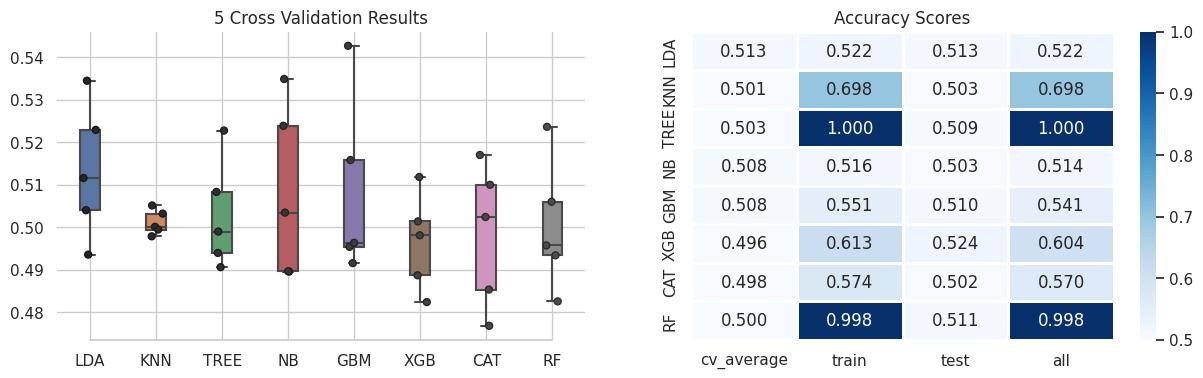

In [38]:
modelEval(df_tr1,split_id=[0.2,None],plot_id=[False,True])

- **<span style='color:#CDE10F'>cross_val_score</span>**가 대략 **<span style='color:#CDE10F'>accuracy = 0.5</span>** 지역에 머무르고 있습니다. 이는 하나의 자산과 관련된 **<span style='color:#CDE10F'>기준 특성</span>**만 사용하는 것이 정확한 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">자산 방향성</mark>**을 예측하는 데 적합하지 않음을 시사합니다.
- 대부분의 모델은 **<span style='color:#CDE10F'>교차 검증 점수</span>**보다 더 높은 **<span style='color:#CDE10F'>훈련 점수</span>**를 기록하는 경향이었습니다.
- 매우 적은 추정자로 심지어 과적합된 상태에서 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">DecisionTreeClassifier</mark>** 및 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">RandomForest</mark>**가 매우 높은 점수를 기록할 수 있는 것은 흥미로웠습니다.
- 이는 트리 기반 모델이 이 문제에서 매우 유용할 수 있으며 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">kNN</mark>**도 교차 검증 점수가 낮기 때문에 훈련 데이터에서 너무 적합한 모델 중 하나로 추가될 수 있음을 시사합니다.

**<span style='color:#CDE10F'>훈련 및 평가 시간</span>**도이 문제에서 상당히 중요합니다:
- (100k/4.5M)만 사용했을 때, 심지어 7개의 특성만 사용한 고급 모델(<code>esp.GBM 및 ANN</code>)의 비용은 매우 높습니다.
- 더 고급 모델은 훈련 시간을 비교 가능한 수준으로 줄이기 위해 크게 조정되어야 했기 때문에 특성 선택 프로세스를 최적화하는 것이 바람직합니다.
- **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">XGB</mark>** 및 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">CATBoost</mark>**는 꽤 빠르게 작동하여 고급 모델로 즉시 사용하기에 매우 최적화되어 있는 것으로 나타났습니다.
- **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">RandomForest</mark>**는 XGB와 유사한 모델임에도 불구하고 훨씬 느립니다.


### <b><span style='color:#CDE10F'> 4.2 |</span> Updated feature model evaluation</b> 

우리는 <code>2.5 섹션</code>에서 <code>feature engineering</code>으로 새로운 특성을 만들었습니다. 업데이트된 특성인 <code>df_feat</code> 데이터프레임을 생성했으니 이러한 새로운 특성을 사용하여 다시 시도해 봅시다.

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price', 'MA21', 'MA63', 'MA252', 'EMA10', 'EMA30', 'EMA200',
       'MOM10', 'MOM30', 'RSI10', 'RSI30', 'RSI200', '%K10', '%K30', '%K200',
       '%D10', '%D30', '%D200'],
      dtype='object')
Target Variable: signal

LDA : 0.906(0.017) -> 1.47s | 0.908 & 0.927 -> 0.36s | 0.910 -> 0.43s
KNN : 0.577(0.016) -> 12.73s | 0.783 & 0.640 -> 18.65s | 0.794 -> 2.1e+01s
TREE : 0.867(0.017) -> 10.35s | 1.000 & 0.894 -> 2.77s | 1.000 -> 3.5s
NB : 0.761(0.012) -> 0.27s | 0.762 & 0.789 -> 0.08s | 0.768 -> 0.08s
GBM : 0.893(0.006) -> 67.17s | 0.897 & 0.905 -> 16.91s | 0.900 -> 2.2e+01s
XGB : 0.918(0.007) -> 3.18s | 0.941 & 0.931 -> 0.47s | 0.940 -> 0.54s
CAT : 0.914(0.009) -> 2.40s | 0.925 & 0.930 -> 0.57s | 0.925 -> 0.66s
RF : 0.900(0.012) -> 31.02s | 1.000 & 0.919

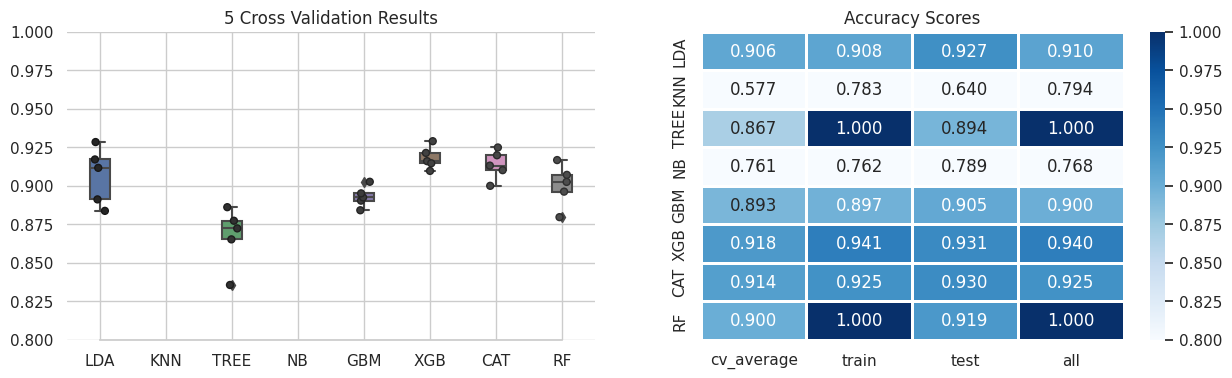

In [39]:
modelEval(df_tr2,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

- **<span style='color:#CDE10F'>정확도</span>** 점수에서 **<span style='color:#CDE10F'>기준 모델</span>**과 비교했을 때 매우 큰 향상이 보입니다.
- **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">LinearDiscriminantAnalysis()</mark>**는 꽤 잘 수행되었습니다. 훈련 세트뿐만 아니라 교차 검증에서도 놀랍게도 가장 빠른 접근 중 하나입니다. 이로 인해 대규모 데이터셋에 대한 가장 효율적인 접근 중 하나가 됩니다.
- 높은 점수를 기록한 모델 중 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">LDA</mark>** 뿐만 아니라 더 고급 모델들인 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">GBM</mark>**,**<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">XGB</mark>**,**<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">CAT</mark>**,**<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">RF</mark>** 등도 놀랍지 않게 높은 성능을 보여줍니다.
- **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">kNN()</mark>** 및 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">GaussianNB()</mark>** 비지도 모델은 지도 학습 모델과 비교했을 때 약간 더 낮은 성능을 보였습니다.



# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#CDE10F"><b><span style='color:#FFFFFF'>5 |</span></b> <b>MODEL EFFICIENCY OPTIMISATION</b></div>

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>UTILISING DIMENSIONALITY REDUCTION</span></b></p></div>

- 문제의 목표를 달성하려고 할 때 마주치는 큰 문제 중 하나는 전체 데이터셋에 대한 많은 틱 데이터(매 분)입니다. 이로 인해 계산 비용이 꽤 높아집니다.
- **<span style='color:#CDE10F'>피처 행렬</span>**이 피처 및 인스턴스 수에 의존하므로 심지어 하나의 불필요한 피처를 제거하면 계산 비용에 뚜렷한 영향을 미칠 것입니다.
- 따라서 모델 정확도와 훈련/예측 속도 간의 문제 균형을 맞추기 위해 가능한 한 많은 불필요한 피처를 제거하는 것이 매우 중요합니다.

<b>두 가지 접근 방식을 살펴보겠습니다:</b>

- <b>(1) 피처 중요도 평가를 통한 차원 축소 (수동적인 접근)</b>

> 이것은 모든 라이브러리가 결합되지 않기 때문에 더 수동적인 프로세스입니다. 그러나 모든 접근 방식 사이에서 공통점을 찾아서 하나의 <code>피처 중요도</code> 평가 접근 방식으로 결합하여 식별하고 평가하며 피처를 제거하여 접근 속도를 높일 수 있도록 해 보겠습니다.

- <b>(2) 비지도 학습 알고리즘을 사용한 차원 축소 (자동화된 프로세스)</b>

> <code>sklearn</code> 라이브러리에는 우리에게 제공되는 강력한 <code>차원 축소</code> 알고리즘의 집합이 있습니다. 유일한 문제는 결과적인 피처의 의미를 설명하는 것이 약간 문제가 될 수 있다는 것입니다.


- 특정한 훈련된 모델들의 **<b>피처 중요도</b>** (FI)를 살펴볼 수 있습니다. 어떤 피처가 얼마나 중요한지를 이해하기 위해.
- 이러한 간소화된 함수를 사용하여 다양한 접근 방식과 최적화된 라이브러리에 의존하여 피처 중요도를 신속하게 평가할 수 있습니다. <b>function</b> <code>feature_importance</code>에는 다음이 포함됩니다:

> - **<span style='color:#CDE10F'>abs()</span>** 함수를 사용한 **<span style='color:#CDE10F'>선형 상관 관계</span>**
> - Catboost Regression 모델의 **<span style='color:#CDE10F'>SHAP 값</span>** (n_est)
> - **<span style='color:#CDE10F'>RandomForest Regressor</span>** (n_est)
> - **<span style='color:#CDE10F'>XGBoost Regressor</span>** (n_est)
> - **<span style='color:#CDE10F'>CatBoost Regressor</span>** (n_est)
> - **<span style='color:#CDE10F'>SelectKBest</span>** (k)

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#CDE10F'>추가 조정</span></b></p></div>

- 개별 점수는 <code>MinMaxScaler()</code>를 사용하여 결합 및 조정되며 플로팅됩니다.
- y 축은 총 점수를 나타내며 (높은 점수가 더 좋음, 최대 -> 접근 방법 수), 
- x 축은 입력 데이터프레임의 해당 피처를 나타냅니다.


In [40]:
from sklearn.feature_selection import SelectKBest,f_regression
from xgboost import plot_importance,XGBRegressor
from catboost import CatBoostClassifier,CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import shap
import seaborn as sns

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot Correlation to Target Variable only
def corrMat(df,target='signal',figsize=(9,0.5),ret_id=False):
    
    corr_mat = df.corr().round(2)
    shape = corr_mat.shape[0]
    corr_mat = corr_mat.transpose()
    corr = corr_mat.loc[:, df.columns == target].transpose().copy()
    
    if(ret_id):
        return corr

''' Feature Importance '''
# Various Approaches for quick FI evaluation

def fi(ldf,target='signal',n_est=25,num_only=True,
       drop_id=None,target_cat=True,drop_na=False):
    
    # Select only numerical features
    if(num_only):
        ldf = ldf.select_dtypes(include=['float64','int64'])    
    
    # Drop all NaN
    if(drop_na):
        print(f'Before NaN drop: {ldf.shape}')
        ldf = ldf.dropna()
        print(f'After NaN dropped: {ldf.shape}')
    
    
    ldf = ldf.copy()
    # If target is categorical string variable
    if(target_cat):
        cats = ldf[target].unique()
        cats_id = [i for i in range(0,len(cats))]
        maps = dict(zip(cats,cats_id))    
        ldf[target] = ldf[target].map(maps)
    
    # If any features are desired to be droped 
    if(drop_id is not None):
        ldf = ldf.drop(drop_id,axis=1)

    # Input dataframe containing feature & target variable
    y = ldf[target]
    X = ldf.drop(target,axis=1)
    
#   CORRELATION
    imp = corrMat(ldf,target,figsize=(15,0.5),ret_id=True)
    del imp[target]
    s1 = imp.squeeze(axis=0);s1 = abs(s1)
    s1.name = 'CORR'
    
#   SHAP
    model = CatBoostRegressor(silent=True,n_estimators=n_est).fit(X,y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap_sum = np.abs(shap_values).mean(axis=0)
    s2 = pd.Series(shap_sum,index=X.columns,name='CAT_SHAP').T
    
#   CATBOOST
    model = CatBoostRegressor(silent=True,n_estimators=n_est).fit(X,y)
    fit = model.fit(X,y)
    rf_fi = pd.DataFrame(model.feature_importances_,index=X.columns,
                                         columns=['CAT'])
    rf_fi.sort_values('CAT',ascending=False)
    s3 = rf_fi.T.squeeze(axis=0)
    
#   RANDOMFOREST
    model = RandomForestRegressor(n_est,random_state=0, n_jobs=-1)
    fit = model.fit(X,y)
    rf_fi = pd.DataFrame(model.feature_importances_,index=X.columns,
                                         columns=['RF'])
    rf_fi.sort_values('RF',ascending=False)
    s4 = rf_fi.T.squeeze(axis=0)

#   XGB 
    model=XGBRegressor(n_estimators=n_est,learning_rate=0.5,verbosity = 0)
    model.fit(X,y)
    data = model.feature_importances_
    s5 = pd.Series(data,index=X.columns,name='XGB').T

#   KBEST
    model = SelectKBest(k=5, score_func=f_regression)
    fit = model.fit(X,y)
    data = fit.scores_
    s6 = pd.Series(data,index=X.columns,name='KBEST')

    # Combine Scores
    df0 = pd.concat([s1,s2,s3,s4,s5,s6],axis=1)
    df0.rename(columns={'target':'lin corr'})

    # MinMax Scaler
    x = df0.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled,index=df0.index,columns=df0.columns)
    df = df.rename_axis(f'<b>FI APPROACH</b>', axis=1)
    df = df.rename_axis('Feature', axis=0)
    
    pd.options.plotting.backend = "plotly"
    fig = df.plot(kind='bar',title='<b>SCALED FEATURE IMPORTANCE</b>',
                  color_discrete_sequence=px.colors.qualitative.T10)
    fig.update_layout(template='plotly_white',height=400,
                     font=dict(family='sans-serif',size=12),
                     margin=dict(l=60, r=40, t=50, b=10))
    fig.update_traces(width=0.25)
    fig.show()

In [41]:
fi(df_tr2)

- We can note that for a lot of features, a small value in <code>correlation</code> magnitude (Pearson's value) also gives small score values in other approaches. Similarly high <code>correlated</code> features tend to have high scores in other <code>feature importance</code> methods, which is quite interesting. There are some exceptions, like <code>%D10</code> & <code>MOM10</code>
- Whilst there are a few features which show some slight dissagreement when it comes to feature importance, overall, <b>feature score similarity can be observed  for most approaches</b>
- It's interesting to note scores of identical feature cases (eg. <code>MOM10</code>, <code>MOM30</code>); we can get an idea of potentially new features that could we could try out ( perhaps <code>MOM20</code> would have worked better than <code>MOM10</code> )
- We can observe a lot of features that have a <b>very low relative score value</b> for most methods, and hence probably have little to no impact, even if they were to be removed
- Removing potentially unimpactful features (which is around 50% of them) would make our whole approach much more efficient, and allow us to focus on more lengthy and in depth <code>hyperparameter</code> gridsearches that hopefully will be more accurate than any of our current models

In [42]:
df_tr2_FI = df_tr2.drop(columns=['Open','High','Low','Close','Volume_(BTC)','Volume_(Currency)','Weighted_Price','MA63','EMA10','%K10'])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index(['MA21', 'MA252', 'EMA30', 'EMA200', 'MOM10', 'MOM30', 'RSI10', 'RSI30',
       'RSI200', '%K30', '%K200', '%D10', '%D30', '%D200'],
      dtype='object')
Target Variable: signal

LDA : 0.903(0.013) -> 0.99s | 0.904 & 0.923 -> 0.26s | 0.906 -> 0.27s
KNN : 0.769(0.037) -> 6.71s | 0.944 & 0.833 -> 8.50s | 0.944 -> 8.5s
TREE : 0.868(0.019) -> 5.83s | 1.000 & 0.895 -> 1.53s | 1.000 -> 1.9s
NB : 0.776(0.010) -> 0.17s | 0.776 & 0.797 -> 0.05s | 0.780 -> 0.052s
GBM : 0.893(0.005) -> 39.59s | 0.898 & 0.905 -> 10.37s | 0.900 -> 1.4e+01s
XGB : 0.919(0.007) -> 1.33s | 0.940 & 0.930 -> 0.32s | 0.938 -> 0.37s
CAT : 0.915(0.008) -> 1.59s | 0.922 & 0.927 -> 0.39s | 0.922 -> 0.43s
RF : 0.907(0.009) -> 23.68s | 1.000 & 0.923 -> 6.32s | 0.999 -> 8.2s


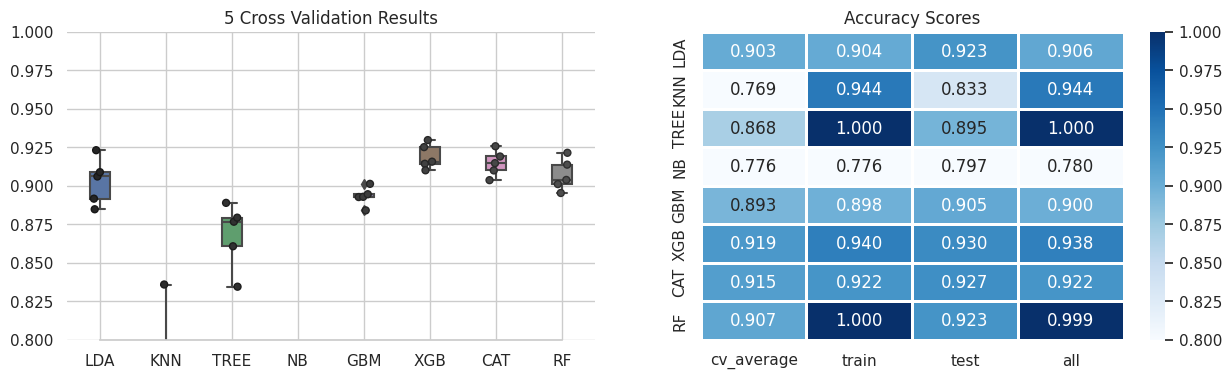

In [43]:
modelEval(df_tr2_FI,split_id=[0.2,None],plot_id=[False,True],cv_yrange=(0.8,1.0),hm_vvals=[0.8,1.0,0.9])

대안적인 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">피처 축소</mark>** 방법은 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">비지도 학습</mark>** 방법을 사용하는 것입니다.
- 알고리즘을 선택해야 합니다 (여러 가지를 살펴보고 어떻게 수행되는지 확인하는 것이 가장 좋습니다),
- 어쩌면 일부 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">스케일링</mark>**을 적용하고 간단히 <code>fit_transform</code>을 적용하여 선택한 차원이 있는 수정된 <code>피처 행렬</code>을 얻을 수 있습니다.

다음 함수에는 다음을 선택할 수 있는 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">비지도 학습</mark>** 알고리즘이 포함되어 있습니다:
> - **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">PCA</mark>**, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Sparse PCA</mark>**, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Kernel PCA</mark>**, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Incremental PCA</mark>**, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Truncated SVD</mark>** 
> - **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Fast ICA</mark>**, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Gaussian Random Projection</mark>**, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Sparse Random Projection</mark>**
> - **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">IsoMap</mark>** (Manifold),**<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">MDS</mark>** (Manifold),**<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">TSNE</mark>** (Manifold)
> - **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Locally Linear Embedding</mark>**, **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Mini Batch Dictionary Learning</mark>**

- 모든 것이 제한된 계산 메모리 (특히 <b>Manifold</b> 접근 방식)으로 인해 캐글에서 실행되지 않을 수 있습니다. 특히 <code>red_mem</code> 함수가 활성화된 경우에도
- **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">manifold</mark>** 방법을 사용하기 전에 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">PCA</mark>** 단계 등 다단계 접근 방식을 사용하는 것은 너무 uncommon하지 않습니다.
- 여기에서는 계산 리소스를 적게 사용하는 방식을 사용할 것입니다.


In [44]:
def dimRed(ldf,feature='signal',split_id=[None,None],n_comp=5,plot_id=True,
           model_id='sparserandomprojection',scaler_id=[False,None]):
    
    # Given a dataframe, split feature/target variable
    X = ldf.copy()
    y = ldf[feature].copy()
    del X[feature]
    
    n_jobs = -1; rs = 32
    
    if(model_id is 'pca'):
        whiten = False
        model = PCA(n_components=n_comp,whiten=whiten,random_state=rs)
    if(model_id is 'sparsepca'):
        alpha = 1
        model = SparsePCA(n_components=n_comp,alpha=alpha,random_state=rs,n_jobs=n_jobs)
    elif(model_id is 'kernelpca'):
        kernel = 'rbf'; gamma = None
        model = KernelPCA(n_components=n_comp,kernel=kernel,gamma=gamma,n_jobs=n_jobs,random_state=rs)
    elif(model_id is 'incrementalpca'):
        batch_size = None
        model = IncrementalPCA(n_components=n_comp,batch_size=batch_size)
    elif(model_id is 'truncatedsvd'): 
        algorithm = 'randomized';n_iter = 5
        model = TruncatedSVD(n_components=n_comp,algorithm=algorithm,n_iter=n_iter,random_state=rs)
    elif(model_id is 'gaussianrandomprojection'):
        eps = 0.5
        model = GaussianRandomProjection(n_components=n_comp,eps=eps,random_state=rs)
    elif(model_id is 'sparserandomprojection'):
        density = 'auto'; eps = 0.5; dense_output = True
        model = SparseRandomProjection(n_components=n_comp,density=density, 
                                       eps=eps, dense_output=dense_output,random_state=rs)
    if(model_id is 'isomap'):
        n_neigh = 2
        model = Isomap(n_neighbors=n_neigh,n_components=n_comp, n_jobs=n_jobs)    
    elif(model_id is 'mds'):
        n_init = 1; max_iter = 50; metric = False
        model = MDS(n_components=n_comp,n_init=n_init,max_iter=max_iter,metric=True,
                    n_jobs=n_jobs, random_state=rs)
    elif(model_id is 'locallylinearembedding'):
        n_neigh = 10; method = 'modified'
        model = LocallyLinearEmbedding(n_neighbors=n_neigh,n_components=n_comp, method=method, \
                                    random_state=rs, n_jobs=n_jobs)
    elif(model_id is 'tsne'):
        learning_rate = 300; perplexity = 30; early_exaggeration = 12; init = 'random'
        model = TSNE(n_components=n_comp, learning_rate=learning_rate, \
                    perplexity=perplexity, early_exaggeration=early_exaggeration, \
                    init=init, random_state=rs)
    elif(model_id is 'minibatchdictionarylearning'):
        alpha = 1; batch_size = 200; n_iter = 25
        model = MiniBatchDictionaryLearning(n_components=n_comp,alpha=alpha,
                                            batch_size=batch_size,n_iter=n_iter,random_state=rs)
    elif(model_id is 'fastica'):
        algorithm = 'parallel'; whiten = True; max_iter = 100
        model = FastICA(n_components=n_comp, algorithm=algorithm,whiten=whiten, 
                          max_iter=max_iter, random_state=rs)
    
    # Scaling 
    if(scaler_id[0]):
        
        opts = [StandardScaler(),RobustScaler(),MinMaxScaler(), Normalizer(norm='l2')]
        scaler = opts[scaler_id[1]].fit(X) 
        X_sca = pd.DataFrame(scaler.fit_transform(X),
                                       columns = X.columns,
                                       index = X.index) # summarize transformed data 
    
    # Unsupervised Dimension Reduction 
    if(scaler_id[0]):
        X_red = model.fit_transform(X_sca)
    else:
        X_red = model.fit_transform(X)
    X_red = pd.DataFrame(data=X_red, index=X.index)
    if(plot_id):
        scatterPlot(X_red, y,model_id)
    X_red[feature] = y
    
    return X_red # return new feature matrix

<code>df_tr2</code>에 <code>dimensionality reduction</code>을 사용한 후에 이전과 같은 방식으로 <code>modelEval</code> 함수를 사용하여 정확도 및 실행 시간을 확인합니다.
차원 축소에는 여기에서 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">Fast ICA</mark>**를 사용하며 다양한 데이터 **<mark style="background-color:#CDE10F;color:white;border-radius:5px;opacity:0.9">스케일링 방법</mark>**과 함께 다양한 조합을 시도할 수 있습니다. 최대한 높은 정확도를 얻는 것이 목표입니다.

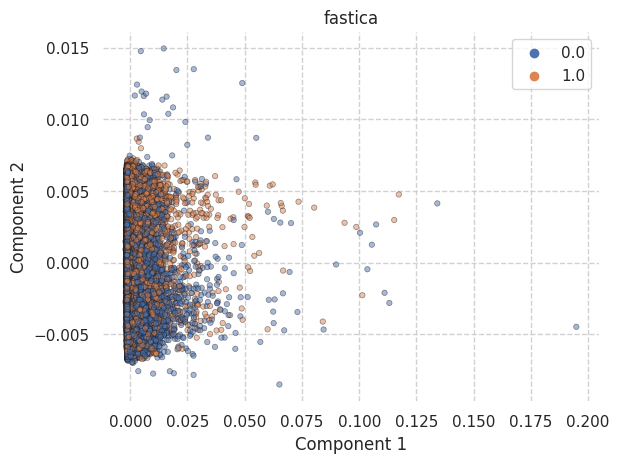

In [45]:
# Standard ICA (no scaling)
df_tr2_ICA = dimRed(df_tr2,
                    split_id=[0.2,None],
                    model_id='fastica',
                    n_comp=5)

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([0, 1, 2, 3, 4], dtype='object')
Target Variable: signal

LDA : 0.829(0.009) -> 0.67s | 0.831 & 0.852 -> 0.16s | 0.836 -> 0.17s
KNN : 0.820(0.014) -> 5.95s | 0.886 & 0.822 -> 6.87s | 0.887 -> 6.9s
TREE : 0.776(0.021) -> 2.81s | 1.000 & 0.771 -> 0.76s | 1.000 -> 0.96s
NB : 0.821(0.021) -> 0.11s | 0.825 & 0.845 -> 0.03s | 0.832 -> 0.035s
GBM : 0.835(0.022) -> 14.73s | 0.840 & 0.862 -> 3.82s | 0.844 -> 4.8s
XGB : 0.840(0.017) -> 0.66s | 0.862 & 0.851 -> 0.17s | 0.860 -> 0.19s
CAT : 0.840(0.016) -> 1.14s | 0.851 & 0.853 -> 0.28s | 0.852 -> 0.32s
RF : 0.830(0.019) -> 19.45s | 0.998 & 0.840 -> 5.41s | 0.998 -> 6.9s


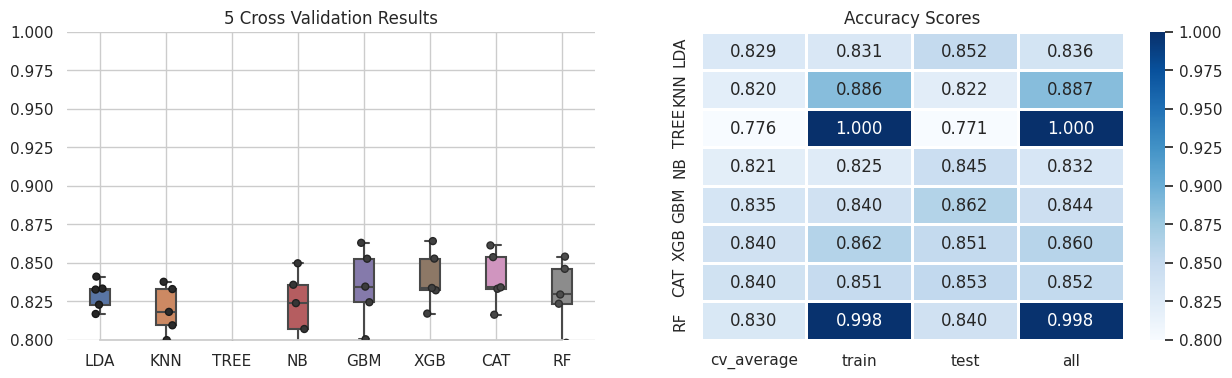

In [46]:
modelEval(df_tr2_ICA,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

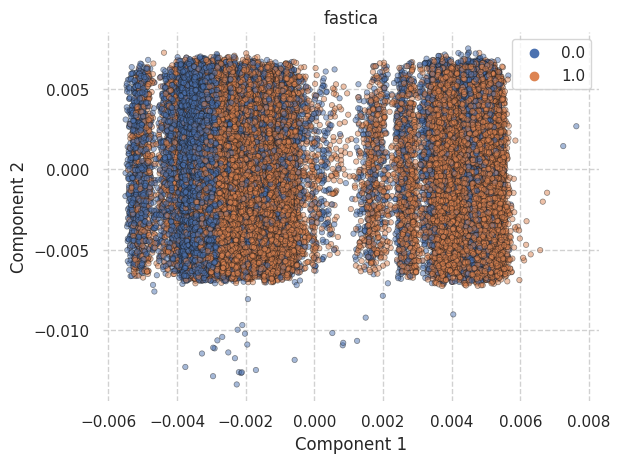

In [47]:
'''StandardScaler ICA'''
df_tr2_ICA_sca0 = dimRed(df_tr2,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,0])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([0, 1, 2, 3, 4], dtype='object')
Target Variable: signal

LDA : 0.828(0.012) -> 0.64s | 0.829 & 0.843 -> 0.20s | 0.835 -> 0.2s
KNN : 0.823(0.010) -> 5.69s | 0.884 & 0.834 -> 6.63s | 0.886 -> 6.6s
TREE : 0.774(0.022) -> 2.42s | 1.000 & 0.782 -> 0.64s | 1.000 -> 0.81s
NB : 0.815(0.009) -> 0.10s | 0.817 & 0.832 -> 0.03s | 0.825 -> 0.034s
GBM : 0.831(0.026) -> 14.78s | 0.839 & 0.855 -> 3.82s | 0.843 -> 4.8s
XGB : 0.839(0.016) -> 0.67s | 0.862 & 0.855 -> 0.18s | 0.864 -> 0.19s
CAT : 0.840(0.014) -> 1.12s | 0.852 & 0.854 -> 0.28s | 0.854 -> 0.32s
RF : 0.831(0.014) -> 17.69s | 0.998 & 0.842 -> 4.92s | 0.998 -> 6.3s


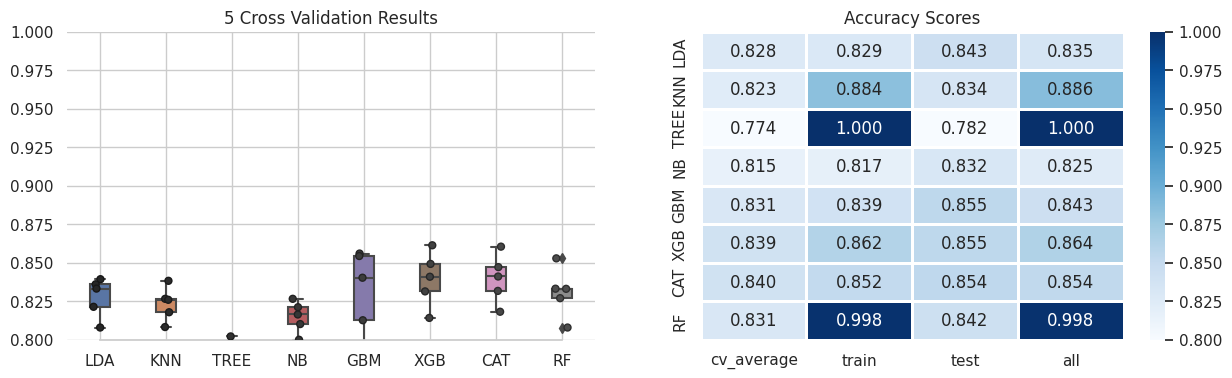

In [48]:
modelEval(df_tr2_ICA_sca0,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

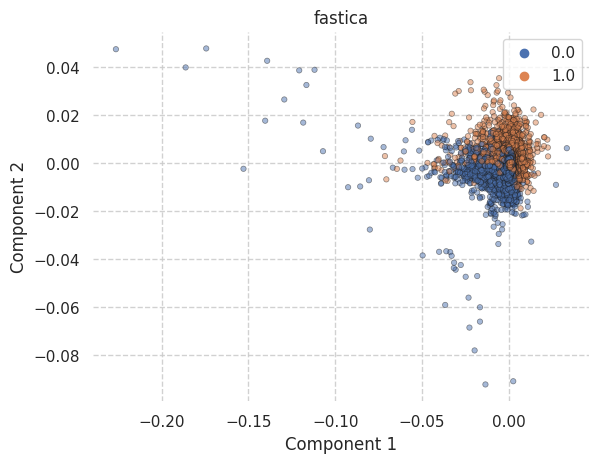

In [49]:
'''RobustScaler ICA'''
df_tr2_ICA_sca1 = dimRed(df_tr2,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,1])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([0, 1, 2, 3, 4], dtype='object')
Target Variable: signal

LDA : 0.815(0.015) -> 0.66s | 0.817 & 0.829 -> 0.20s | 0.821 -> 0.2s
KNN : 0.827(0.016) -> 5.77s | 0.883 & 0.831 -> 6.72s | 0.886 -> 6.8s
TREE : 0.780(0.021) -> 2.36s | 1.000 & 0.788 -> 0.67s | 1.000 -> 0.83s
NB : 0.789(0.015) -> 0.12s | 0.790 & 0.806 -> 0.03s | 0.799 -> 0.035s
GBM : 0.823(0.011) -> 15.05s | 0.829 & 0.843 -> 3.95s | 0.833 -> 4.9s
XGB : 0.838(0.016) -> 0.76s | 0.866 & 0.861 -> 0.17s | 0.865 -> 0.2s
CAT : 0.839(0.018) -> 1.12s | 0.853 & 0.862 -> 0.28s | 0.854 -> 0.32s
RF : 0.833(0.019) -> 17.41s | 0.998 & 0.850 -> 4.99s | 0.998 -> 6.2s


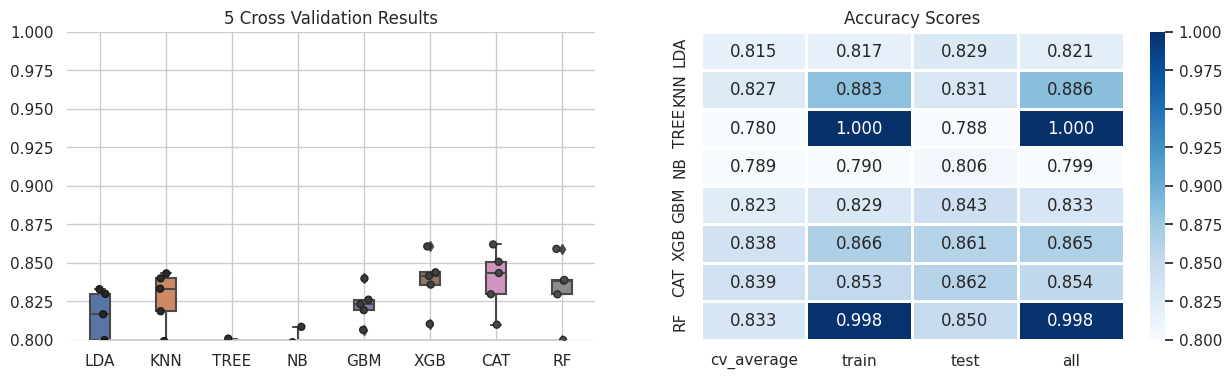

In [50]:
modelEval(df_tr2_ICA_sca1,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

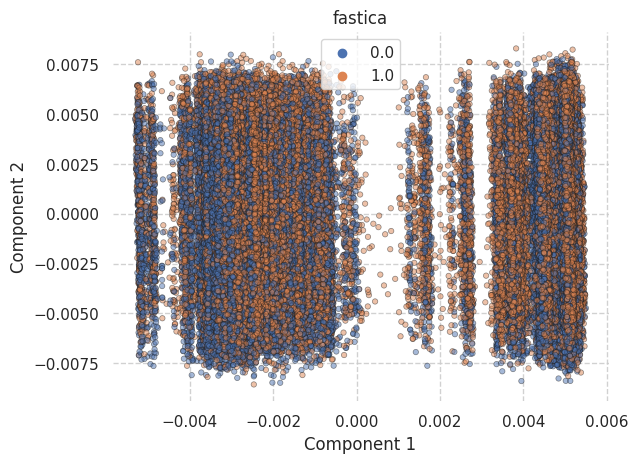

In [51]:
'''MinMaxScaler ICA'''
df_tr2_ICA_sca2 = dimRed(df_tr2,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,2])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([0, 1, 2, 3, 4], dtype='object')
Target Variable: signal

LDA : 0.834(0.011) -> 0.59s | 0.835 & 0.859 -> 0.20s | 0.840 -> 0.17s
KNN : 0.812(0.011) -> 5.31s | 0.881 & 0.837 -> 6.33s | 0.883 -> 6.3s
TREE : 0.764(0.020) -> 2.32s | 1.000 & 0.799 -> 0.64s | 1.000 -> 0.8s
NB : 0.825(0.012) -> 0.11s | 0.825 & 0.857 -> 0.03s | 0.829 -> 0.035s
GBM : 0.832(0.011) -> 15.20s | 0.834 & 0.855 -> 3.87s | 0.839 -> 4.9s
XGB : 0.832(0.018) -> 1.87s | 0.857 & 0.863 -> 0.18s | 0.861 -> 0.19s
CAT : 0.834(0.017) -> 1.10s | 0.846 & 0.860 -> 0.28s | 0.851 -> 0.33s
RF : 0.822(0.017) -> 17.82s | 0.999 & 0.853 -> 4.90s | 0.999 -> 6.3s


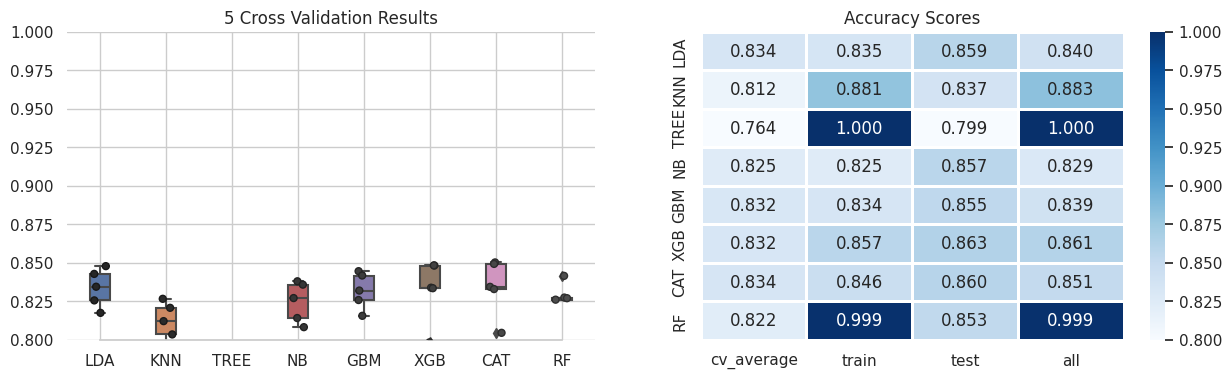

In [52]:
modelEval(df_tr2_ICA_sca2,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

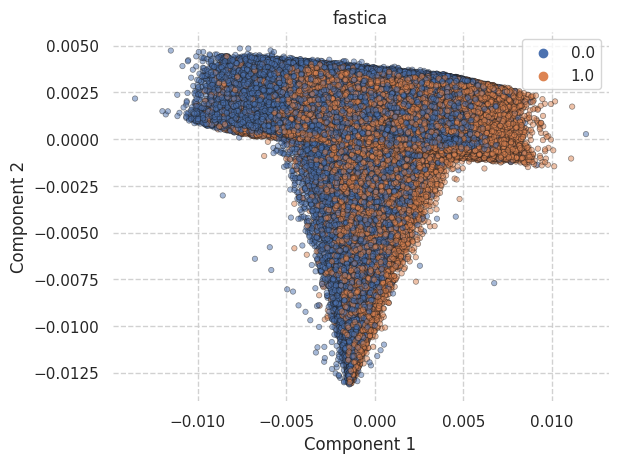

In [53]:
'''Normaliser ICA'''
df_tr2_ICA_sca3 = dimRed(df_tr2,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,3])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([0, 1, 2, 3, 4], dtype='object')
Target Variable: signal

LDA : 0.818(0.020) -> 0.62s | 0.821 & 0.846 -> 0.20s | 0.826 -> 0.2s
KNN : 0.799(0.016) -> 5.22s | 0.860 & 0.816 -> 6.14s | 0.863 -> 6.2s
TREE : 0.752(0.019) -> 2.50s | 1.000 & 0.760 -> 0.69s | 1.000 -> 0.86s
NB : 0.802(0.023) -> 0.10s | 0.809 & 0.835 -> 0.03s | 0.811 -> 0.034s
GBM : 0.811(0.014) -> 15.21s | 0.820 & 0.837 -> 3.86s | 0.823 -> 4.9s
XGB : 0.820(0.016) -> 0.66s | 0.836 & 0.845 -> 0.17s | 0.839 -> 0.2s
CAT : 0.820(0.017) -> 1.12s | 0.827 & 0.845 -> 0.29s | 0.832 -> 0.32s
RF : 0.808(0.017) -> 19.09s | 0.997 & 0.829 -> 5.29s | 0.998 -> 6.8s


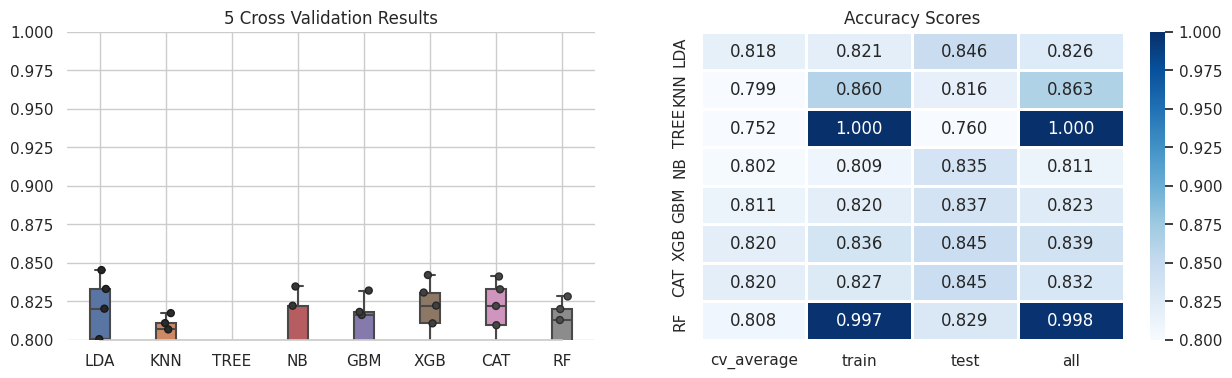

In [54]:
modelEval(df_tr2_ICA_sca3,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])